In [17]:
import pylab
import ringdown.qnms
import numpy as np
import matplotlib.pyplot as plt
import qnm
import lal
from collections import namedtuple
import math
from scipy.optimize import curve_fit
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries

In [9]:
import surfinBH
fit_name = 'NRSur3dq8Remnant'
fit = surfinBH.LoadFits(fit_name)

Loaded NRSur3dq8Remnant fit.


In [10]:
q = 1.24             # Mass ratio q>=1
chiA = [0,0,0]    # Spin of larger BH (z-direction only)
chiB = [0,0,0]    # Spin of smaller BH (z-direction only)

## Evaluate the fits and GPR error estimate.

# remnant mass and 1-sigma error estimate
mf, mf_err = fit.mf(q, chiA, chiB)

# remnant spin and 1-sigma error estimate
chif, chif_err = fit.chif(q, chiA, chiB)

# remnant recoil kick and 1-sigma error estimate
vf, vf_err = fit.vf(q, chiA, chiB)

# All of these together
mf, chif, vf, mf_err, chif_err, vf_err = fit.all(q, chiA, chiB)

In [11]:
print(mf, chif)
m_f = mf*(36+29)
print(m_f)
# mf is returning m2/m1...so multiply it by (m1+m2)!!!!

0.9526684300679796 [0.         0.         0.68007186]
61.92344795441868


In [18]:
hp, hc = get_td_waveform(approximant="IMRPhenomXP",
                         mass1=36,
                         mass2=29,
                         delta_t=1.0/16384,
                         f_lower=30)

# this is trimming timeseries hp.sample_times and hp/hc data to start at 0 for ringdown analysis
hp_smp_ts = TimeSeries(hp.sample_times, delta_t=1/16384, epoch=0) #turning sample times into timeseries to use crop
cond = hp_smp_ts.crop(0.645,0) #using crop on timeseries sample times 
#use cond for cropped sample times!!!!!

hp_data = TimeSeries(hp, delta_t=1/16384, epoch=0) #turning h+ data into timeseries to use crop
cond_hp = hp_data.crop(0.645,0) #using crop on timeseries data
#use cond_hp for the cropped hp data pts!!!!
#repeating for hx data points
hc_data = TimeSeries(hc, delta_t=1/16384, epoch=0)
cond_hc = hc_data.crop(0.645,0)
hc_signal = cond_hc.numpy() #turning into ndarray

time = cond.numpy()

In [21]:
def rngdwn(M,chi,l,m,n,amplitude,phi):
    pylab.figure(figsize=pylab.figaspect(0.4))
    ftau = ringdown.qnms.get_ftau(M,chi,n,l,m)
    gamma = (ftau[1])**-1
    t0=0
    time = cond.numpy()
        
    wf_kws = dict(
    A = amplitude,
    phi = phi,
    f = ftau[0],
    gamma = gamma,
    )
        
    def get_signal(time, A, phi, f, gamma):
        s = A*np.cos(2*np.pi*f*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
        return ringdown.Data(s, index=time)

    signal = get_signal(time, **wf_kws)
    
    return signal

<Figure size 720x288 with 0 Axes>

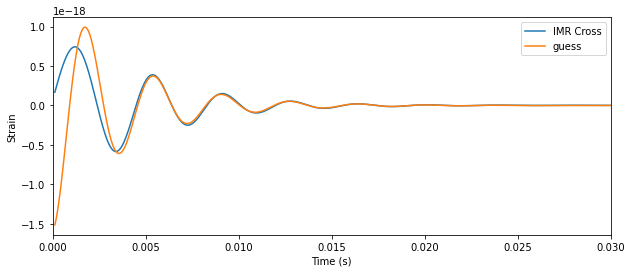

In [22]:
pylab.figure(figsize=pylab.figaspect(0.4))
surfin = rngdwn(62,0.68,2,2,0,1.6e-18,np.pi)
pylab.plot(cond, cond_hc, label='IMR Cross')
pylab.plot(surfin,label='guess')
pylab.xlim(0, 0.03)
#pylab.axvline(x=0.0085,linestyle='dashed') use this for 1e-18 and phi=0
#pylab.axvline(x=0.0115,linestyle='dashed')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
#plt.savefig('hmfit')
#print(dir(signal))
#print(signal._values)

In [23]:
surfin_res = (surfin._values) - (cond_hc)

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

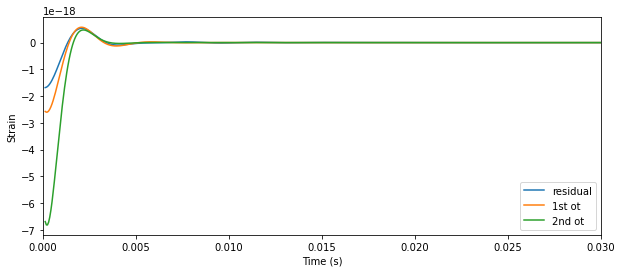

In [42]:
pylab.figure(figsize=pylab.figaspect(0.4))
surfin1 = rngdwn(62,0.68,2,2,1,3.4e-18,((3*np.pi)/4))
surfin2 = rngdwn(62,0.68,2,2,2,12e-18,((2*np.pi)/3))
pylab.plot(time,surfin_res,label='residual')
pylab.plot(surfin1,label='1st ot')
pylab.plot(surfin2,label='2nd ot')
pylab.xlim(0, 0.03)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()

In [60]:
def two_two_zero(time,M,chi,l,m,n,amplitude,phi):
    pylab.figure(figsize=pylab.figaspect(0.4))
    ftau = ringdown.qnms.get_ftau(M,chi,n,l,m)
    gamma = (ftau[1])**-1
    t0=0
    time = cond.numpy()
        
    wf_kws = dict(
    A = amplitude,
    phi = phi,
    f = ftau[0],
    gamma = gamma,
    )
        
    def get_signal(time, A, phi, f, gamma):
        s = A*np.cos(2*np.pi*f*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
        return ringdown.Data(s, index=time)

    signal = get_signal(time, **wf_kws)

    return signal

In [61]:
xdata = time
ydata = cond_hc
p0 = [62,0.68,2,2,0,1.6e-18,np.pi]
popt,pcov = curve_fit(two_two_zero,xdata,ydata,p0)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>